In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


**In this project, we will use the Tweets dataset regarding different American airlines to identify the main reason that customers complain about the airlines and wrote negative tweets. We also create a sentiment prediction model using DistilBERT large language model**

# EDA

In [29]:
# Needed Libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Data Collection

In [6]:
# connecting to the SQLite database
conn = sqlite3.connect('/kaggle/input/twitter-airline-sentiment/database.sqlite')

In [7]:
# run a sql query to read and create pandas dataframe
query = "SELECT * FROM Tweets"
df = pd.read_sql_query(query, conn)

## Data Inspection

In [8]:
# let's look at the first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [9]:
# let's look at the last 5 rows
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada)
14484,570310600460525568,negative,0.6292,Flight Booking Problems,0.3146,US Airways,,jhazelnut,,0,@USAirways is there a better time to call? My...,,2015-02-24 11:53:37 -0800,,


##### You can see that there are some cells empty, and for dealing with them, we need to first replace them with NaN values. In the data cleaning section, we will do it.

In [15]:
# Dimensions of dataframe
df.shape

(14485, 15)

In [16]:
# let's check the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14485 non-null  int64         
 1   airline_sentiment             14485 non-null  object        
 2   airline_sentiment_confidence  14485 non-null  float64       
 3   negativereason                9082 non-null   object        
 4   negativereason_confidence     10416 non-null  float64       
 5   airline                       14485 non-null  object        
 6   airline_sentiment_gold        40 non-null     object        
 7   name                          14485 non-null  object        
 8   negativereason_gold           32 non-null     object        
 9   retweet_count                 14485 non-null  int64         
 10  text                          14485 non-null  object        
 11  tweet_coord                 

#### based on the above cell, we can see that the data type of column "tweet_created" is not correct. It should be datetime dtype but now it is object (string). We will deal with it in the data cleaning section

## Data Cleaning

In [17]:
# replace empty cells with NaN values, so we can handle them later
df.replace("", np.nan, inplace=True)

In [18]:
# Correct the data type of column'tweet_created' (keep only the date and convert its data type to datetime)
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

#### Let's see the earliest and the latest dates of the dataset

In [78]:
print('The earliest date: ', max(df['tweet_created']))
print('The latest date: ', min(df['tweet_created']))

The earliest date:  2015-02-24 00:00:00
The latest date:  2015-02-16 00:00:00


In [21]:
# Identifying the percentage of missing values
null_percentage = df.isnull().mean() * 100
null_percentage

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.300656
negativereason_confidence       28.091129
airline                          0.000000
airline_sentiment_gold          99.723852
name                             0.000000
negativereason_gold             99.779082
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.047981
tweet_created                    0.000000
tweet_location                  32.357611
user_timezone                   32.965136
dtype: float64

#### Above 90% of columns 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord' are null values. So, we need to delete these columns as they do not have any valuable information

In [ ]:
# Drop the mentioned columns
df = df.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1)

#### For creating the prediction model of sentiment, we need to make our 'text' column ready for that. We convert the tweets to tokens, remove stopwords, remove @ tags, convert all letter to lowercase. Stopwords are those which do not add that much meaningful information to texts. By removing stopwords, we reduce the dimensionality of the feature space, and focus on more meaningful words.

In [31]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

df['text'] = df['text'].apply(lambda x: ' '.join(
    [word for word in word_tokenize(' '.join([word for word in ' '.join(
        [word for word in x.split() if word.isalnum()]).split() if not word.startswith("@")])) if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Let's see the frequency of each sentiment class in our dataset

In [58]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9082
neutral     3069
positive    2334
Name: count, dtype: int64

#### Let's see the reasons of negative reviews! It is important to know what the problems in the airlines, so they can improve it. 

In [29]:
df['negativereason'].value_counts()

negativereason
Customer Service Issue         2885
Late Flight                    1650
Can't Tell                     1176
Cancelled Flight                829
Lost Luggage                    719
Bad Flight                      575
Flight Booking Problems         523
Flight Attendant Complaints     475
longlines                       177
Damaged Luggage                  73
Name: count, dtype: int64

#### We can see that the Customer Service Issue was the main and the biggest issue amongst airlines as a whole. Late Flight is the second major problem of airlines. But, let's look at each airline individually.

In [34]:
grouped_df = df.groupby('airline')['negativereason'].size()
grouped_df

airline
American          2604
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: negativereason, dtype: int64

#### American Airlines has the highest number of tweets, while Virgin America has the least. 
#### Now, let's check the percentage of negative, positive, and neutral tweets.

In [39]:
df_grouped_airsent = df.groupby(['airline', 'airline_sentiment']).size().unstack(fill_value=0)
percentage = df_grouped_airsent.div(df_grouped_airsent.sum(axis=1), axis=0) * 100
percentage

airline_sentiment,negative,neutral,positive
airline,,,
American,71.582181,16.628264,11.789555
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


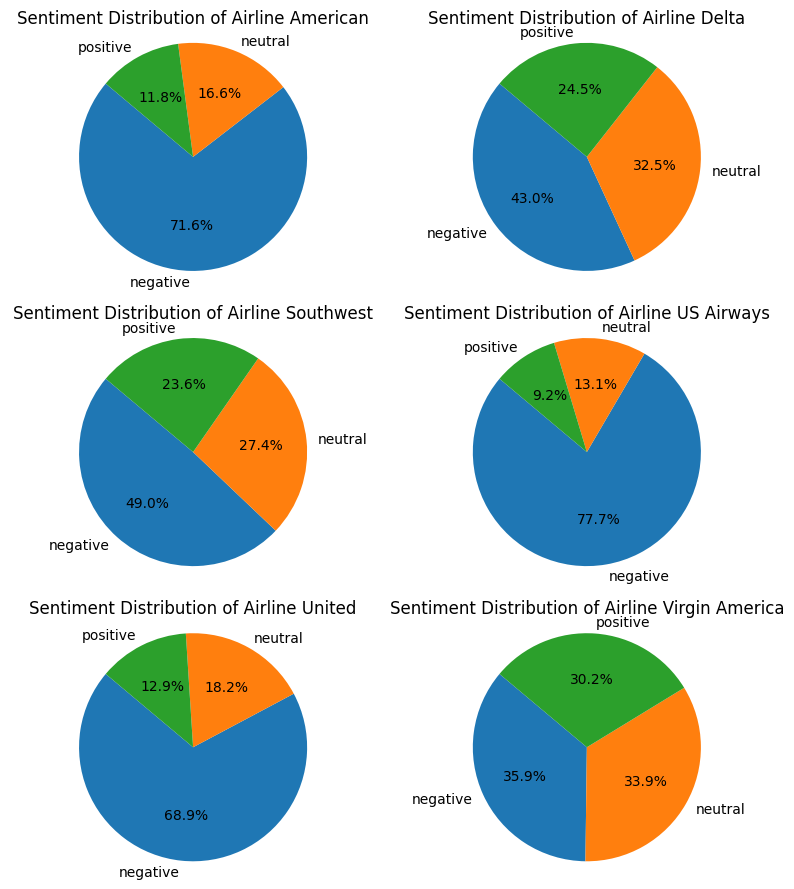

In [45]:
# plot pie charts showing the percentage of each class for each airline

fig, axes = plt.subplots(3, 2, figsize=(8, 3 * 3))
axes = axes.flatten()
for i, airline in enumerate(percentage.index):
    axes[i].pie(percentage.loc[airline], labels=percentage.columns, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'Sentiment Distribution of Airline {airline}')
    axes[i].axis('equal')

    
plt.tight_layout()
plt.show()    

#### Looking at the pie charts above, we can see that nearly 78% of US Airways tweets are negative. American Airlines is the second airline with the highest portion of negative tweets. Conversely, Virgin America has the highest percentage of positive tweets, followed by Delta and Southwest. An interesting insight from the figure is that negative sentiment is the majority class across all airlines.

### But now, let's see what is the main reason of negative tweets!

In [46]:
grouped = df.groupby(['negativereason', 'airline']).size().reset_index(name='count')


In [47]:
# what is the main reason for each airline?
main_reasons = grouped.sort_values('count', ascending=False).drop_duplicates(['airline'])
print(main_reasons)

            negativereason         airline  count
21  Customer Service Issue      US Airways    811
18  Customer Service Issue        American    743
22  Customer Service Issue          United    681
20  Customer Service Issue       Southwest    391
43             Late Flight           Delta    269
23  Customer Service Issue  Virgin America     60


#### Customer Service Issue is most important reason of all airlines except for the airline Delta, which Late Flight is the main reason.

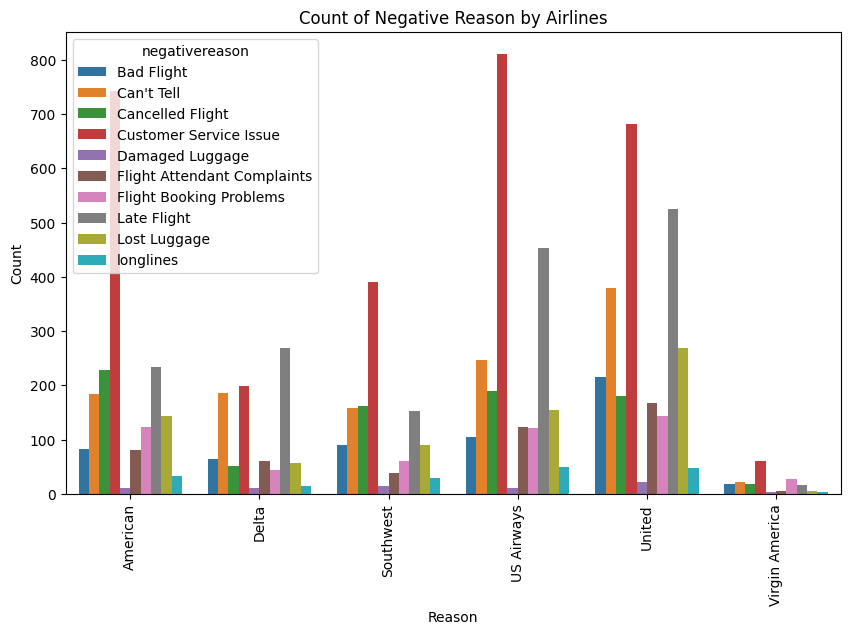

In [48]:
# Visulization is the better way to see the frequency of each reason for each airline

plt.figure(figsize=(10, 6))
sns.barplot(x='airline', y='count', hue='negativereason', data=grouped)
plt.title('Count of Negative Reason by Airlines')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#### From the above figure, we can see that 'Customer Service Issue' by far is the most important reason. Also, for Delta, this reason is the second most frequent reason. Another important takeaway from this figure is that Virgin America airline has the lowest amount of tweet amongst other airlines.

#### Now, I want to look at the wordCloud of tweets for each airline to see what the most repeated words in tweets

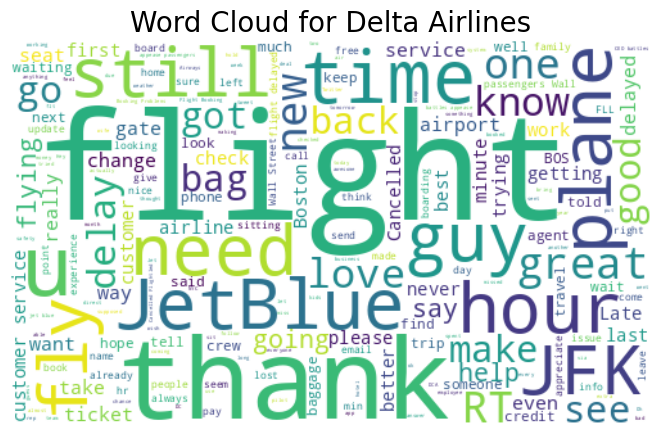

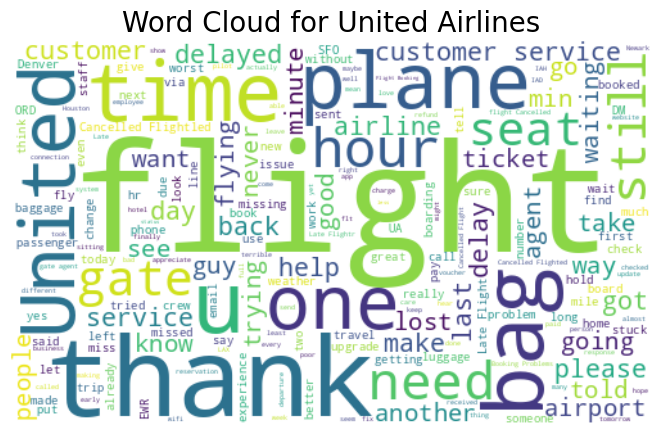

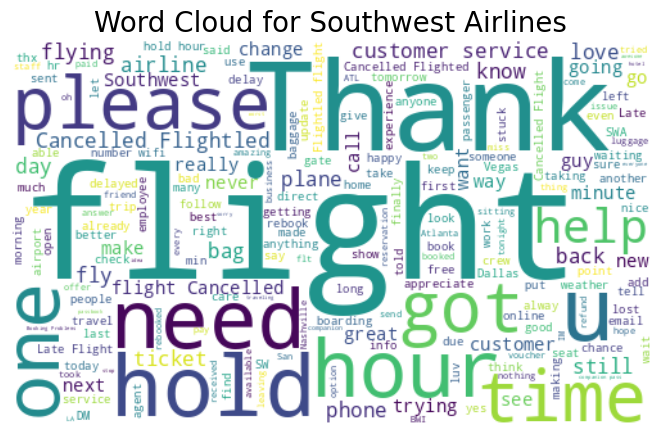

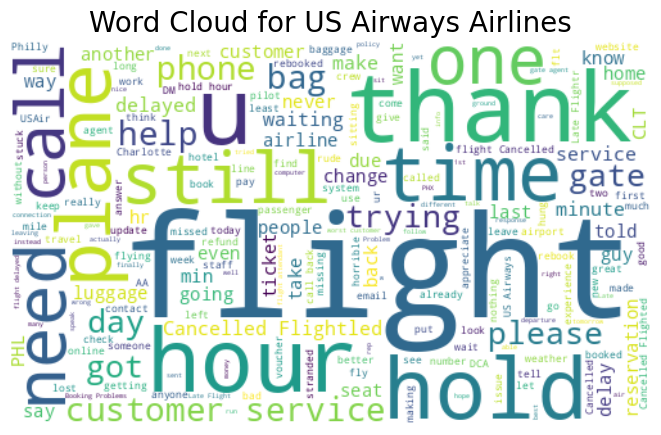

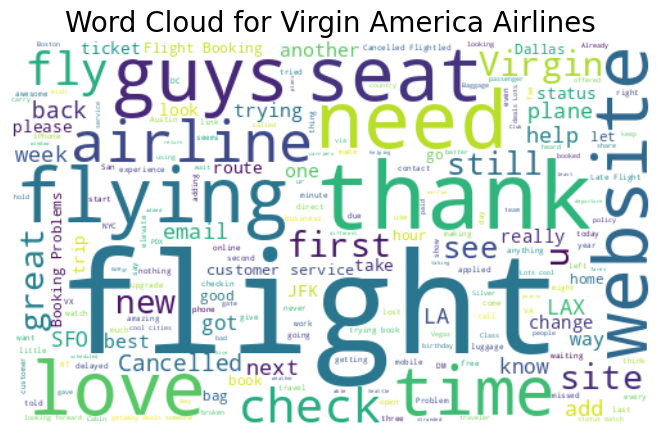

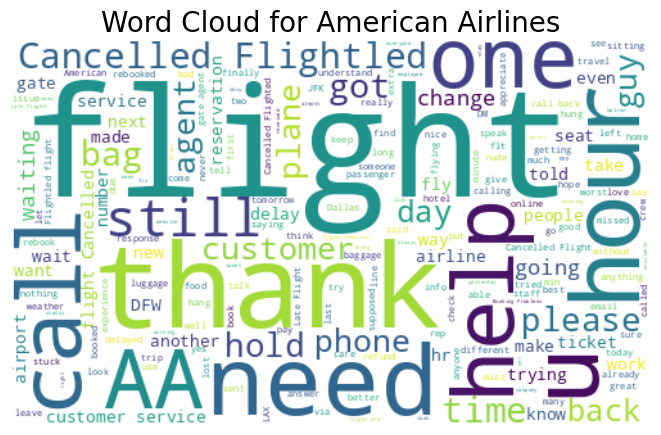

In [73]:
from wordcloud import WordCloud, STOPWORDS

def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(width=500, height=300, stopwords=STOPWORDS, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.show()

airlines = df['airline'].unique()
for airline in airlines:
    airline_tweets = df[df['airline'] == airline]['text']
    combined_text = ' '.join(airline_tweets)
    generate_wordcloud(combined_text, title=f'Word Cloud for {airline} Airlines')

#### The WordCloud for each airline highlights some of the common problems and complaints tweeted by customers. For example, for American Airlines, we can see that words such as "Call", "Still", "Hold", or "Hour" frequently appear, indicating waiting on the customer service line is one of the main issues. American Airlines should pay attention to this problem and probably increase the number of customer service staff.

#### Now, I want to create the model to predict the sentiment of tweets about airlines.

In [49]:
df['text']

0        new CEO seeks right balance please passengers ...
1                                    REALLY getting nerves
2        waited line almost hour passengers left wantin...
3        got gate IAH time given seats closed know peop...
4        cool bags take bit dont give baggage blue caro...
                               ...                        
14480                     hope fly often would hate change
14481                                DM possible following
14482                                Yesterday way EWR FLL
14483                                 one agents available
14484    better time flight Friday need change Worried ...
Name: text, Length: 14485, dtype: object

## Feature Engineering
#### Create features using pre-trained embeddings (DistilBERT) for building prediction model for the sentiment of tweets. Below, we will use DistilBERT pre-train model to convert text data to numerical feature vectors (embeddings) which can capture semantic information from text.

In [50]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

# Break the dataframe into smaller chunks if necessary
chunk_size = 500  # Process 500 rows at a time if memory is an issue
features = []

for start in range(0, len(df), chunk_size):
    end = start + chunk_size
    text_chunk = df['text'][start:end].tolist()
    
    # Tokenize the chunk
    encoded_texts = tokenizer.batch_encode_plus(
        text_chunk,
        add_special_tokens=True,
        max_length=256,  # Reduced max_length
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoded_texts['input_ids'].to(device)
    attention_masks = encoded_texts['attention_mask'].to(device)

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, batch_size=8)  # Reduced batch size

    # Process each batch
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks = batch

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            last_hidden_states = outputs.last_hidden_state
            features_chunk = last_hidden_states[:, 0, :].detach().cpu().numpy()
            features.append(features_chunk)

    torch.cuda.empty_cache()  # Attempt to clear cached memory that's no longer needed

# Concatenate the features from each chunk
features = np.concatenate(features, axis=0)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#### Here we utilize XGBoost algorithm for the prediction model. We will use features array that we created earlier above. 
#### XGBoost is one the most popular machine learning algorithm, especially for classification tasks.

In [57]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


#features_filtered = features[df['airline_sentiment'] != 'neutral']
#y = df[df['airline_sentiment'] != 'neutral']['airline_sentiment'].replace({'positive': 1, 'negative': 0})
y = df['airline_sentiment'].replace({'positive': 2, 'negative': 0, 'neutral': 1})

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=1)

# Initialize the XGBoost classifier with optimized parameters
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',  
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=1
)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = xgb_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Build the confusion matrix
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report_df)


/tmp/ipykernel_34/4189970412.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['airline_sentiment'].replace({'positive': 2, 'negative': 0, 'neutral': 1})


Accuracy: 0.731446323783224
Confusion Matrix:
 [[1645  132   45]
 [ 304  247   49]
 [ 182   66  227]]
Classification Report:
               precision    recall  f1-score      support
negative       0.771938  0.902854  0.832279  1822.000000
neutral        0.555056  0.411667  0.472727   600.000000
positive       0.707165  0.477895  0.570352   475.000000
accuracy       0.731446  0.731446  0.731446     0.731446
macro avg      0.678053  0.597472  0.625119  2897.000000
weighted avg   0.716399  0.731446  0.714866  2897.000000


#### Looking at the classification report table, we can see that the model performed well overall with around 73% accuracy. 
#### Moreover, the model performed best on the negative class, but not on other two classes, positive and neutral. This could be due to the class imbalance, which we have more negative instances in our dataset. 
#### One way to improve the model is to undersample or oversample the dataset and then feed to the model. We will use SMOTE which is a Oversampling technique to make the dataset balance.

In [65]:
from imblearn.over_sampling import SMOTE

y = df['airline_sentiment'].replace({'positive': 2, 'negative': 0, 'neutral': 1})

smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(features, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',  
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=1
)

xgb_clf.fit(X_train, y_train)


y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Build the confusion matrix
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report_df)

/tmp/ipykernel_34/1545451121.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['airline_sentiment'].replace({'positive': 2, 'negative': 0, 'neutral': 1})


Accuracy: 0.865137614678899
Confusion Matrix:
 [[1534  245   92]
 [ 136 1531   66]
 [  60  136 1650]]
Classification Report:
               precision    recall  f1-score      support
negative       0.886705  0.819882  0.851986  1871.000000
neutral        0.800732  0.883439  0.840055  1733.000000
positive       0.912611  0.893824  0.903120  1846.000000
accuracy       0.865138  0.865138  0.865138     0.865138
macro avg      0.866683  0.865715  0.865053  5450.000000
weighted avg   0.868142  0.865138  0.865512  5450.000000


#### By looking at the table above, we can see that the metrics have been improved and SMOTE technique improved the prediction model.